# Anhang
Dieses [Notebook](https://colab.research.google.com/drive/1YA8WVQ2xnD8Pn0Nb1beSiLPtgsakwWW4) stellt eine Beispielanwendung von Convolutional Neural Networks in Python mit [*Keras*](https://keras.io/) und [*Tensorflow*](https://www.tensorflow.org/) vor.
Es wird ein CNN Architektur definiert und anschließend dazu trainiert, Bildklassifikation durchzuführen. Als Datensatz wird [*CIFAR-10*](https://www.cs.toronto.edu/~kriz/cifar.html) verwendet.
Anschließend werden Anhand eines bewährten vortrainierten Models ([*VGG16*](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)) die Feature maps zu einem bestimmten Bild visualisiert. 


# Convolutional Neural Network für Bildklassifizierung 
## Datensatz
*CIFAR-10* besteht aus 60000 32x32 Farbbildern aus 10 Klassen:

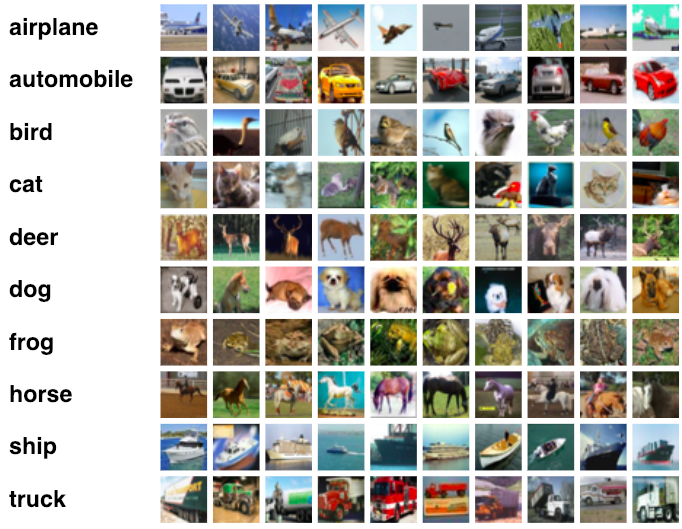

In [0]:
from IPython.display import Image
Image('/content/cifar10.png')

## Imports und Hilfsfunktionen

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf


def plot_images(data):
  plt.figure(figsize=(10,3))
  for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i])

def plot_compare(history):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.xlabel('Epoche')
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.xlabel('Epoche')
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()
    
    plt.tight_layout()
    

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

def vgg_predict(path):
  
  model = VGG16()
  image = load_img(path, target_size=(224, 224))
  plt.imshow(image)
  plt.axis('off')
  plt.show()
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  
  image = preprocess_input(image)
  yhat = model.predict(image)
  label = decode_predictions(yhat)
  label = label[0][0]
  
  print('%s (%.2f%%)' % (label[1], label[2]*100))

Using TensorFlow backend.


## Datensatz laden
Keras kommt mit einer Bibliothek [datasets]( https://keras.io/datasets/), welche man nutzen kann um Datensätze direkt vom Server zu laden ( in unserem Fall: cifar10).

In [0]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

## Analyse
Als nächstes werden wir uns den Datensatz genauer anschauen und uns vergewissern, dass es sich wirklich um 60000 32x32 Farbbilder mit 10 Klassen handelt.

In [0]:
print('Training data shape : ', x_train.shape, y_train.shape)

print('Testing data shape : ', x_test.shape, y_test.shape)

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)


In [0]:
classes = np.unique(y_train)
nClasses = len(classes)
print('number of classes : ', nClasses)

number of classes :  10


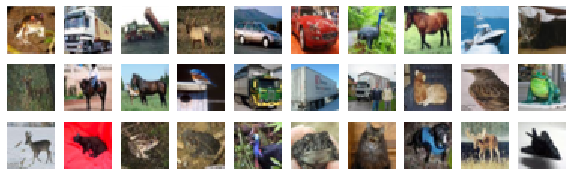

In [0]:
# 30 erste Bilder
plot_images(x_train)

## Vorverarbeitung
Zunächst werden wir die Daten normalisieren.

In [0]:
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

Im Moment sind die Labels als Nummern von 0-9 gegeben. Da benutzen One Hot Encoding um die Label als 10 stellgen Vektor zu kodieren. Beispielsweise wird dann aus der Nummer 3 der Vektor [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

In [0]:
# Onehot encode Labels
from keras.utils.np_utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

print('Original label:', y_train[0])
print('One hot encoded label:', y_train_one_hot[0])

Original label: [6]
One hot encoded label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Damit unser Modell gut generalisiert, werden wir 20% des Trainingdatensatzes für Validierung nutzen. Das reduziert *Overfitting* und führt so zu besserer Test Performanz.

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train_one_hot,y_valid_one_hot = train_test_split(x_train, y_train_one_hot,
                                                           test_size=0.1, random_state=21)

# check shapes, just to make sure
x_train.shape,x_valid.shape,y_train_one_hot.shape,y_valid_one_hot.shape

((45000, 32, 32, 3), (5000, 32, 32, 3), (45000, 10), (5000, 10))

Ein weitere Vorverarbeitungschritt besteht darin, den Trainingsdatensatz zu augmentieren. Für Bilder bspw., werden weiter Bilder generiert, die z.B rotiert, geneigt, verschoben, etc sind. Wir nutzen hierfür die [ImageDataGenerator](https://keras.io/preprocessing/image/) Klasse von Keras. Der generator muss defienert und anschließend 

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.1,
                             rotation_range=30,
                             horizontal_flip=True)       

# berechnet benötigte Quantitäten wie std, mean, etc.
datagen.fit(x_train)

train_generator = datagen.flow(x_train, y_train_one_hot, shuffle=True)

## Modellierung
Für das Convolutional Neural Network, anhand wir unser Modell trainieren wollen, legen wir eine Architektur fest. Zunächst werden alle nötigen Module importiert.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, LeakyReLU

Nach dem man ein Modell instantiiert hat, lassen sich in Keras lassen die Netwerkschichten (Layer) stapeln in dem man sie nacheinander einfügt (*add()*). Wir werden mehrere Convolutional Layer mit LeakyReLU als Aktivierungsfunktion benutzen. Auf jeden Convolutional Layer folgt eine MayPooling Schicht. *Flatten* transformiert die featuremaps in einen Vektor, der von vollständig vernetzten Schichten mit SoftMax zum Output verarbeitet wird.

In [0]:
# Feed Forward network
my_model = Sequential()

# Der erste Layer muss wissen was für eine Form der Input hat
my_model.add(Conv2D(32,(3,3), padding="same", activation='relu',
                    input_shape = x_train.shape[1:]))
my_model.add(Conv2D(32,(3,3), padding="same", activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))

my_model.add(Conv2D(64,(3,3), padding="same", activation='relu'))
my_model.add(Conv2D(64,(3,3), padding="same", activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))

my_model.add(Conv2D(128,(3,3), padding ="same", activation='relu'))
my_model.add(Conv2D(128,(3,3), padding ="same", activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))

# Vectorization + DropOut
my_model.add(Flatten())
my_model.add(Dropout(0.5))

# Fully Connected Layer
my_model.add(Dense(128, activation='relu'))
my_model.add(Dense(64, activation='relu'))
my_model.add(Dense(10, activation='softmax'))

Das Modell lässt sich mit *summary()* visualisieren (Output-shape, Parameteranzahl)

In [0]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)         73856     
__________

Nach dem wir das Modell kreiiert haben, müssen wir es kompilieren. Hierbei werden u.A. die [Verlustfunktion](https://keras.io/losses/) und der [Optimizer](https://keras.io/optimizers/) (beihaltet Lernrate, etc.) festgelegt. 

In [0]:
my_model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['accuracy'])

## Training
Nun werden wir unser Modell trainieren. Das geschieht normalerweise durch *fit()*. Da wir jedoch einen Generator für die Datenaugmentierung genutzt haben, verwenden wir *fit_generator()*. Wir trainieren für 20 Epochen. Der Output der Funktion speichern, wir in einer *history* variable um die Metriken plotten zu können.




In [0]:
history = my_model.fit_generator(
        train_generator,
        epochs=20,
        verbose=1,
        validation_data=(x_valid, y_valid_one_hot))

Epoch 1/20
1407/1407 [==============================] - 43s 30ms/step - loss: 1.9443 - acc: 0.2740 - val_loss: 1.5585 - val_acc: 0.4298
Epoch 2/20
1407/1407 [==============================] - 41s 29ms/step - loss: 1.6049 - acc: 0.4141 - val_loss: 1.3923 - val_acc: 0.4948
Epoch 3/20
1407/1407 [==============================] - 41s 29ms/step - loss: 1.4292 - acc: 0.4837 - val_loss: 1.1830 - val_acc: 0.5652
Epoch 4/20
1407/1407 [==============================] - 41s 29ms/step - loss: 1.3152 - acc: 0.5294 - val_loss: 1.1433 - val_acc: 0.5948
Epoch 5/20
1407/1407 [==============================] - 41s 29ms/step - loss: 1.2427 - acc: 0.5574 - val_loss: 1.0134 - val_acc: 0.6370
Epoch 6/20
1407/1407 [==============================] - 41s 29ms/step - loss: 1.1907 - acc: 0.5748 - val_loss: 1.0496 - val_acc: 0.6314
Epoch 7/20
1407/1407 [==============================] - 41s 29ms/step - loss: 1.1466 - acc: 0.5950 - val_loss: 1.0279 - val_acc: 0.6382
Epoch 8/20
1407/1407 [==========================

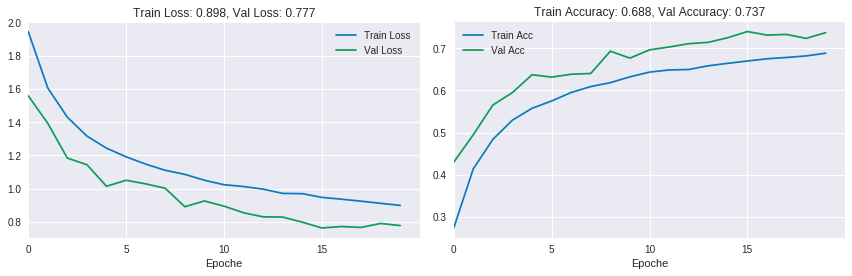

In [0]:
plot_compare(history)

## Evaluierung
Nach dem wir das Modell trainiert haben, wollen wir wissen wie akkurat wir den Testdatensatz klassifizieren können. Wie man sieht, konnten wir selbst mit dem verhältnismäßig einfachen Modell 72% des Testdatensatzes richtig klassifizieren.

In [0]:
test_eval = my_model.evaluate(x_test, y_test_one_hot, verbose=1)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

10000/10000 [==============================] - 2s 208us/step
Test loss: 0.8087519835472107
Test accuracy: 0.723


Es macht jedoch Sinn, nicht nur die Performance allgemein anzuschauen, sondern innerhalb der einzelnen Klassen.  'Accuracy' als Maß kann jedoch irreführend sein (siehe [Link](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/)). Daher nutzen wir 'Precision' und 'Recall'. Generell ist gewollt, alle Werte hoch sind. 

In [0]:
predicted_classes = my_model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

from sklearn.metrics import classification_report
target_names = ['Airplane','Automobile','Bird','Cat',
                'Deer','Dog','Frog','Horse','Ship','Truck']
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Airplane       0.31      0.85      0.45      1000
  Automobile       0.90      0.83      0.86      1000
        Bird       0.82      0.43      0.56      1000
         Cat       0.80      0.30      0.43      1000
        Deer       0.81      0.53      0.64      1000
         Dog       0.81      0.43      0.56      1000
        Frog       0.66      0.86      0.75      1000
       Horse       0.85      0.71      0.77      1000
        Ship       0.87      0.83      0.85      1000
       Truck       0.78      0.88      0.82      1000

   micro avg       0.66      0.66      0.66     10000
   macro avg       0.76      0.66      0.67     10000
weighted avg       0.76      0.66      0.67     10000



Um das Modell mit zu speichern kann man *save()* aufrufen. Anhand der gespeicherten Datei kann man das Modell später wieder laden.

In [0]:
my_model.save("/content/cifar10_cnn.h5py")



---

# Bildklassifizierung mit VGG16
Für den nächsten Abschnitt benutzen wir ein bestehendes Modell. Die [VGG Modelle](https://arxiv.org/pdf/1409.1556.pdf) haben 2014 bei der [ImageNet](http://www.image-net.org/) Challenge die ersten Plätze belegt und eigne sich daher besonders gut um Bilder jeglicher Art zu klassifizieren. In Keras lässt sich das Modell samt Gewichte (trainiert auf ImageNet) wiefolgt laden:

In [0]:
from keras.applications import VGG16
vgg = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 20s 0us/step


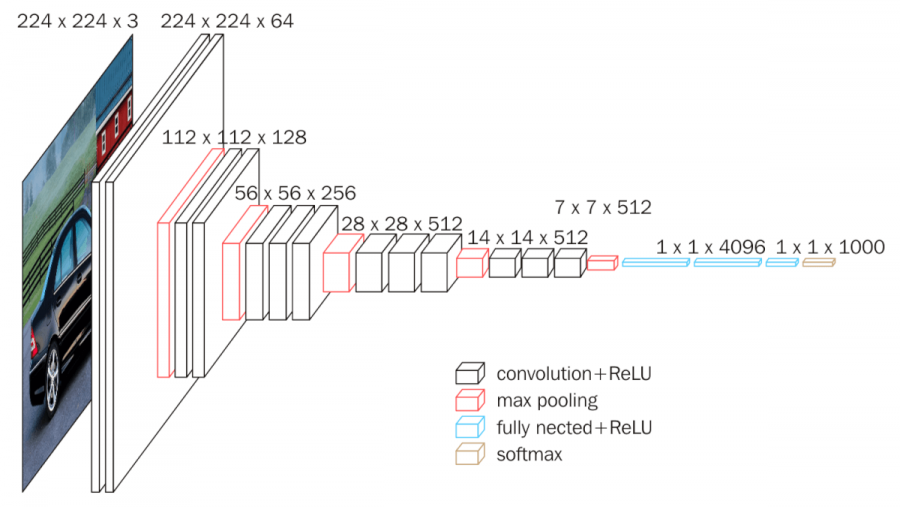

In [0]:
Image('/content/vgg16-1-e1542731207177.png')

In [0]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Klassifizierung nach VGG16
Wir haben eine Funktion (*vgg_predict()*)geschrieben anhand der man jegliche Bilder mit VGG16 klassifizieren kann.

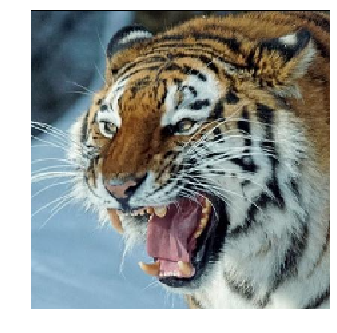

tiger (85.78%)


In [0]:
vgg_predict("/content/tiger.png")

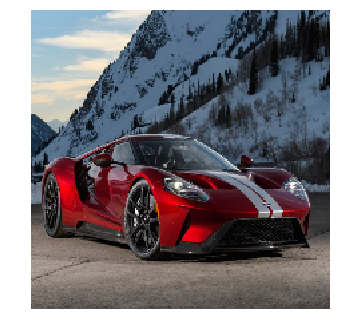

sports_car (75.89%)


In [0]:
vgg_predict("/content/car.jpg")

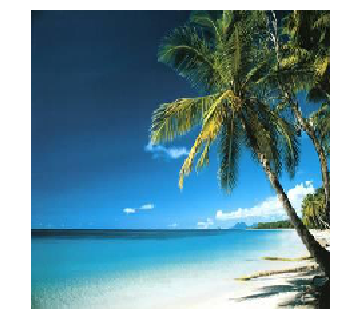

seashore (84.35%)


In [0]:
vgg_predict("/content/beach.jpg")

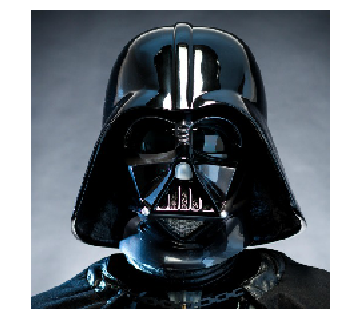

electric_fan (41.20%)


In [0]:
vgg_predict("/content/darth-vader.jpg")

## Visualisierung der Feature maps
Man kann die Aktivierungen an den einzelnen Schichten visualisieren. In dem man ein Bild durch das Netz schickt und zufällig feauture maps auswählt. Da die Schichten für das Keras-VGG16 model benannt sins kann man gezielt sich nur die feature maps der convolutional layer anschauen. In diesem Beispiel stehe helle Farben für eine hohe Aktivierung. (Der Code für diesen Teil wurde entnommen aus einem [Blog Beitrag](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2) und leicht angepasst).

(1, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


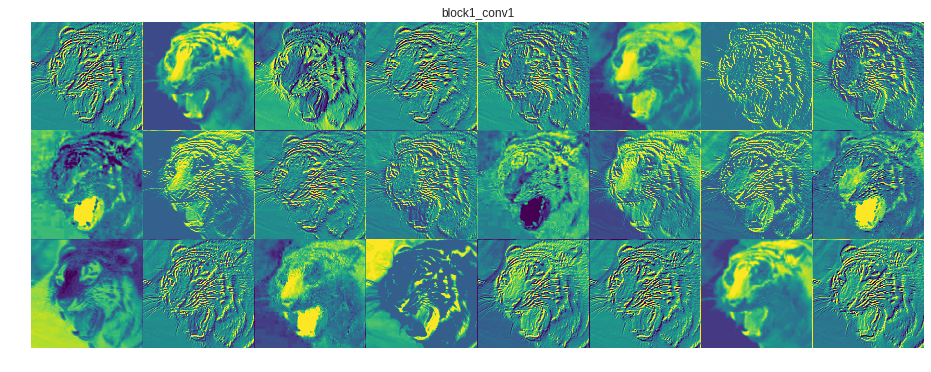

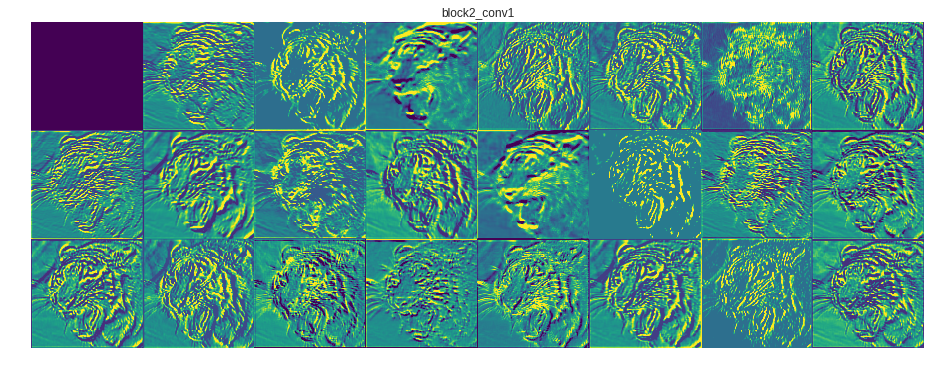

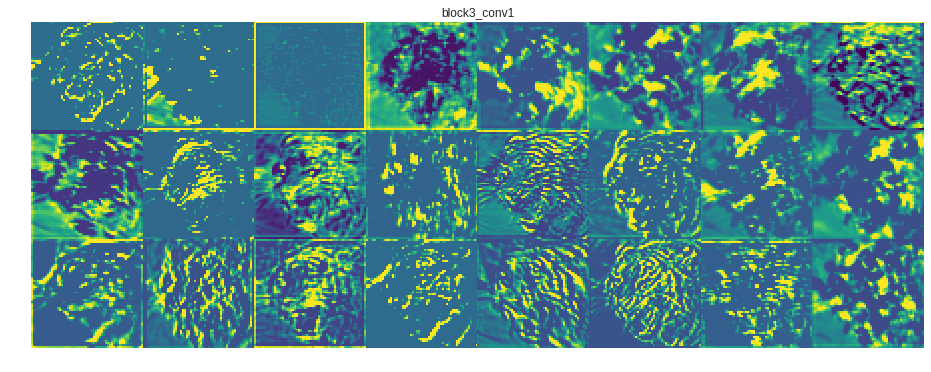

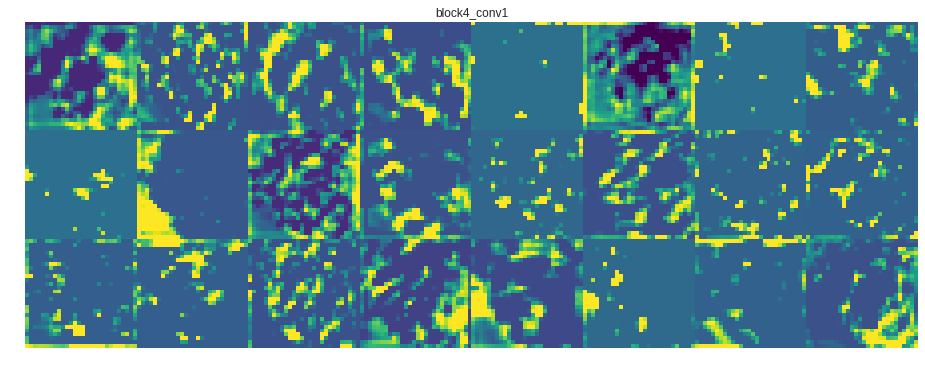

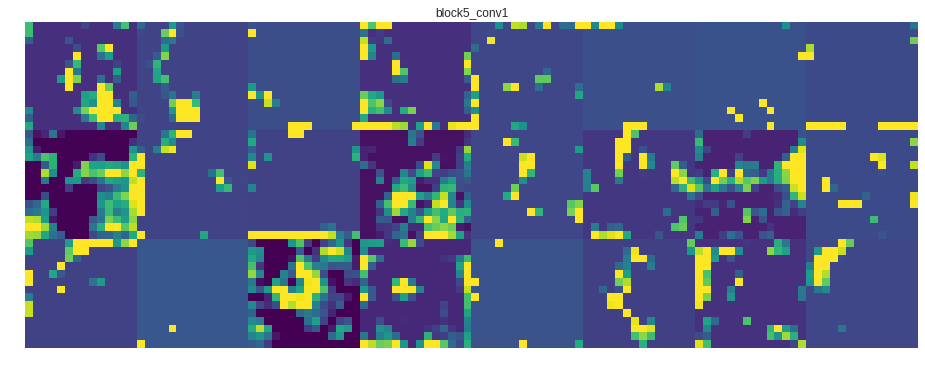

In [0]:
from keras.models import Model

img_tensor = image_tensor('/content/tiger.png')
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 24
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()